Note: this version is outdated. This was the original attempt to characterize the L plate using measurements of I rather than Q (new method)
The comparison between the two mehtods is shown in the newer files that use the SuperK SELECT laser rather than the Thorlabs broadband lamp

In [1]:
import numpy as np
from numpy.linalg import inv
from astropy.io import fits
import os
import re
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import textwrap

In [2]:
# Theta from 0 to 180 degrees (for the first QWP). The second QWP rotates at 5 times this rate (25 degree increments)
theta = np.linspace(0, np.pi, 37) # 5 degree increments for the first QWP
longtheta = np.linspace(0, np.pi, 46) # 4 degree increments (this is preferred) 
degtheta = theta*180/np.pi

In [3]:
# Define the identity matrix and other matrices which are useful for the Mueller calculus
M_identity = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])
A = np.array([1, 0, 0, 0])
B = np.array([[1], [0], [0], [0]])

In [4]:
# Mueller matrix for a linear polarizer, with angle a between transmission axis and horizontal (radians)
def linear_polarizer(a):
    M01 = np.cos(2*a)
    M02 = np.sin(2*a)
    M10 = np.cos(2*a)
    M11 = np.cos(2*a)**2
    M12 = np.cos(2*a)*np.sin(2*a)
    M20 = np.sin(2*a)
    M21 = np.cos(2*a)*np.sin(2*a)
    M22 = np.sin(2*a)**2

    return 0.5*np.array([[1, M01, M02, 0], 
                         [M10, M11, M12, 0], 
                         [M20, M21, M22, 0], 
                         [0, 0, 0, 0]])

In [5]:
# Mueller matrix for a linear retarder (waveplate). Angle of fast axis a, retardance r in radians
def linear_retarder(a, r):
    M11 = np.cos(2*a)**2 + np.cos(r)*np.sin(2*a)**2
    M12 = np.cos(2*a)*np.sin(2*a)*(1-np.cos(r))
    M13 = -np.sin(2*a)*np.sin(r)
    M21 = M12
    M22 = np.sin(2*a)**2 + np.cos(2*a)**2*np.cos(r)
    M23 = np.cos(2*a)*np.sin(r)
    M31 = -M13
    M32 = -M23
    M33 = np.cos(r)

    return np.array([[1, 0, 0, 0], 
                     [0, M11, M12, M13], 
                     [0, M21, M22, M23], 
                     [0, M31, M32, M33]])

In [6]:
# Sorting function for extracting filenames based on last number in the filename (the angle of rotation)
def extract_number(filename):
    match = re.findall(r'\d+(?:\.\d+)?', filename)
    if match:
        return float(match[-1])

In [7]:
# Function to subtract dark frames from raw frames. The new reduced images are saved to a different folder
def dark_subtraction(image_file, dark_file, old_directory, new_directory):
    # Open the dark image and extract pixel values
    fits.open(dark_file)
    dark = fits.getdata(dark_file)
    dark_median = np.median(dark, axis=0)

    # Search through the desired raw data folder
    for filename in os.listdir(old_directory):
        if filename.startswith(image_file):                                # Call specific files starting with the desired name
            with fits.open(os.path.join(old_directory, filename)) as hdul:
                img_data = hdul[0].data
                img_median = np.median(img_data, axis=0)
                reduced_data = img_median - dark_median

            # Save the newly reduced image to a reduced data folder
            new_filename = f"Reduced_{filename}"
            new_filepath = os.path.join(new_directory, new_filename)
            fits.writeto(new_filepath, reduced_data, overwrite=True)

In [8]:
# Get intensity values from each spot in the reduced images. reduced_filename should just be the start of the name (leave out the last number, the angle). 
def extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff=5000):
    I_left = np.array([])
    I_right = np.array([])
    bad_indices = np.array([])
    longtheta = np.linspace(0, np.pi, 46)

    for filename in sorted(os.listdir(reduced_folder), key = extract_number):
        if filename.startswith(reduced_filename):
            with fits.open(os.path.join(reduced_folder, filename)) as hdul:
                reduced_img_data = hdul[0].data
                ys, xs, = np.indices(reduced_img_data.shape)
                lradius = np.sqrt((ys-lcenter[0])**2+(xs-lcenter[1])**2)
                rradius = np.sqrt((ys-rcenter[0])**2+(xs-rcenter[1])**2)

                lbackground_mask = (lradius > 20) & (lradius < 26)
                rbackground_mask = (rradius > 20) & (rradius < 26)   # Index the background around each spot, take the median value

                background_lmedian = np.median(reduced_img_data[lbackground_mask])
                background_rmedian = np.median(reduced_img_data[rbackground_mask])

                lflux = np.sum(reduced_img_data[lradius < maxradius] - background_lmedian)   # Now take the flux with the background mask subtracted
                rflux = np.sum(reduced_img_data[rradius < maxradius] - background_rmedian)
                I_left = np.append(I_left, lflux)
                I_right = np.append(I_right, rflux)

                if lflux+rflux < cutoff:
                    print("Warning: low flux detected, check the image " + filename + ", index: " + str(sorted(os.listdir(reduced_folder), key = extract_number).index(filename)))
                    bad_indices = np.append(bad_indices, sorted(os.listdir(reduced_folder), key = extract_number).index(filename))
                else:
                    continue 

    # Makes the array a list of integers that can be used to index the other array
    bad_indices = bad_indices.astype(int)
    # Deletes the bad indices from the data
    I_left = np.delete(I_left, bad_indices)
    I_right = np.delete(I_right, bad_indices)
    new_angles = np.delete(longtheta, bad_indices)

    return I_left, I_right, new_angles, bad_indices

In [9]:
# Gives the condition number of eventual Mueller matrix (made by Jaren)
def condition_number(matrix):
    minv = np.linalg.pinv(matrix)

    # Compute maximum norm
    norm = np.linalg.norm(matrix, ord=np.inf)
    ninv = np.linalg.norm(minv, ord=np.inf)

    return norm*ninv

In [10]:
# Function to compute the Mueller matrix of a sample based on DRRP intensity measurements. Big thanks to Jaren for this part!
def original_full_mueller_polarimetry(thetas, I_meas=1, LPA_angle=0, return_condition_number=False, M_in=None):
    nmeas = len(thetas)
    Wmat = np.zeros([nmeas, 16])
    Pmat = np.zeros([nmeas])
    th = thetas

    for i in range(nmeas):
        # Mueller Matrix of generator (linear polarizer and a quarter wave plate)
        Mg = linear_retarder(th[i], np.pi/2) @ linear_polarizer(0)

        # Mueller Matrix of analyzer (one channel of the Wollaston prism is treated as a linear polarizer. The right spot is horizontal (0) and the left spot is vertical(pi/2))
        Ma = linear_polarizer(LPA_angle) @ linear_retarder(th[i]*5, np.pi/2)

        # Data reduction matrix. Taking the 0 index ensures that intensity is the output
        Wmat[i,:] = np.kron(Ma[0,:], Mg[:,0])

        # M_in is some example Mueller matrix. Providing this input will test theoretical Mueller matrix. Otherwise, the raw data is used
        if M_in is not None:
            Pmat[i] = (Ma[0,:] @ M_in @ Mg[:,0]) * I_meas
        else:
            Pmat[i] = I_meas[i]

    # Compute Mueller matrix using Moore-Penrose pseudo invervse
    M = np.linalg.pinv(Wmat) @ Pmat
    M = np.reshape(M,[4,4])

    if return_condition_number == True:
        return M, condition_number(Wmat)
    else:
        return M

In [11]:
# Function to compute the Mueller matrix of a sample based on DRRP intensity measurements and calibration parameters
def calibrated_full_mueller_polarimetry(thetas, a1, a2, w1, w2, r1, r2, I_meas=1, LPA_angle=0, return_condition_number=False, M_in=None):
    nmeas = len(thetas)
    Wmat = np.zeros([nmeas, 16])
    Pmat = np.zeros([nmeas])
    th = thetas

    for i in range(nmeas):
        # Mueller Matrix of generator (linear polarizer and a quarter wave plate)
        Mg = linear_retarder(th[i]+w1, np.pi/2+r1) @ linear_polarizer(0+a1)

        # Mueller Matrix of analyzer (one channel of the Wollaston prism is treated as a linear polarizer. The right spot is horizontal (0) and the left spot is vertical(pi/2))
        Ma = linear_polarizer(LPA_angle+a2) @ linear_retarder(th[i]*5+w2, np.pi/2+r2)

        # Data reduction matrix. Taking the 0 index ensures that intensity is the output
        Wmat[i,:] = np.kron(Ma[0,:], Mg[:,0])

        # M_in is some example Mueller matrix. Providing this input will test theoretical Mueller matrix. Otherwise, the raw data is used
        if M_in is not None:
            Pmat[i] = (Ma[0,:] @ M_in @ Mg[:,0]) * I_meas
        else:
            Pmat[i] = I_meas[i]

    # Compute Mueller matrix using Moore-Penrose pseudo invervse
    M = np.linalg.pinv(Wmat) @ Pmat
    M = np.reshape(M,[4,4])

    if return_condition_number == True:
        return M, condition_number(Wmat)
    else:
        return M

In [12]:
# This is the full Mueller matrix equation for our setup. The output is a list, useful for curve fitting. Variables with 1 refer to the generator, 2 refers to analyzer. 
def calibration_function(t, a1, a2, w1, w2, r1, r2):
    prediction = [None]*len(t)
    for i in range(len(t)):
        prediction[i] = float(A @ linear_polarizer(a2) @ linear_retarder(5*t[i]+w2, np.pi/2+r2) @ M_identity @ linear_retarder(t[i]+w1, np.pi/2+r1) @ linear_polarizer(a1) @ B)
    return prediction

In [13]:
# Calibration function designed for data from the left spot, which is the vertial alignment. This changes the angle of the analyzing LP
def vertical_calibration_function(t, a1, a2, w1, w2, r1, r2):
    prediction = [None]*len(t)
    for i in range(len(t)):
        prediction[i] = float(A @ linear_polarizer(a2+np.pi/2) @ linear_retarder(5*t[i]+w2, np.pi/2+r2) @ M_identity @ linear_retarder(t[i]+w1, np.pi/2+r1) @ linear_polarizer(a1) @ B)
    return prediction

In [14]:
# Basically the same as above, but with an optional input matrix to simulate data
def output_simulation_function(t, a1, a2, w1, w2, r1, r2, M_in=None):
    if M_in is None:
        M = M_identity
    else:
        M = M_in

    prediction = [None]*len(t)
    for i in range(len(t)):
        prediction[i] = float(A @ linear_polarizer(a2) @ linear_retarder(5*t[i]+w2, np.pi/2+r2) @ M @ linear_retarder(t[i]+w1, np.pi/2+r1) @ linear_polarizer(a1) @ B)
    return prediction

In [15]:
# After testing, each of the above functions works individually. Now combine them into one function to rule them all
# Finds the mueller matrix derived from each channel separately, then averages the two retardances found this way
# First three inputs must come from the calibration data, last three inputs correspond to the HWP sample
def ultimate_polarimetry(cal_angles, cal_left_intensity, cal_right_intensity, sample_angles, sample_left_intensity, sample_right_intensity):
    initial_guess = [0, 0, 0, 0, 0, 0]
    parameter_bounds = ([-np.pi/4, -np.pi/4, -np.pi/4, -np.pi/4, -np.pi/4, -np.pi/4], [np.pi/4, np.pi/4, np.pi/4, np.pi/4, np.pi/4, np.pi/4])

    # Find parameters from calibration of the left spot
    lnormalized_intensity = cal_left_intensity/(2*max(cal_left_intensity))
    lpopt, lpcov = curve_fit(vertical_calibration_function, cal_angles, lnormalized_intensity, p0=initial_guess, bounds=parameter_bounds)
    #print(lpopt, "Parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer")
    #print(np.sqrt(np.diag(lpcov)))

    # Find parameters from calibration of the right spot
    rnormalized_intensity = cal_right_intensity/(2*max(cal_right_intensity))
    rpopt, rpcov = curve_fit(calibration_function, cal_angles, rnormalized_intensity, p0=initial_guess, bounds=parameter_bounds)
    #print(rpopt, "Parameters for a1, a2, w1, w2, r1, and r2. 1 for generator, 2 for analyzer")
    #print(np.sqrt(np.diag(rpcov)))

    # Optional print the calibration matrices (should be close to identity) to see how well the parameters compensate
    MlCal = calibrated_full_mueller_polarimetry(cal_angles, lpopt[0], lpopt[1], lpopt[2], lpopt[3], lpopt[4], lpopt[5], cal_left_intensity, LPA_angle=np.pi/2)
    print(MlCal/MlCal.max(), ' Left calibration')
    MrCal = calibrated_full_mueller_polarimetry(cal_angles, rpopt[0], rpopt[1], rpopt[2], rpopt[3], rpopt[4], rpopt[5], cal_right_intensity)
    print(MrCal/MrCal.max(), ' Right calibration')

    # Use the parameters found above from curve fitting to construct the actual Mueller matrix of the sample
    Ml = calibrated_full_mueller_polarimetry(sample_angles, lpopt[0], lpopt[1], lpopt[2], lpopt[3], lpopt[4], lpopt[5], sample_left_intensity, LPA_angle=np.pi/2)
    Ml = Ml/Ml.max()

    Mr = calibrated_full_mueller_polarimetry(sample_angles, rpopt[0], rpopt[1], rpopt[2], rpopt[3], rpopt[4], rpopt[5], sample_right_intensity)
    Mr = Mr/Mr.max()

    np.set_printoptions(suppress=True)

    # Extract retardance from the last entry of the mueller matrix, which should just be cos(phi)
    lretardance = np.arccos(Ml[3,3])/(2*np.pi)
    rretardance = np.arccos(Mr[3,3])/(2*np.pi)
    print(lretardance, ' This is the retardance found from the left spot')
    print(rretardance, ' This is the retardance found from the right spot')

    avg_retardance = (lretardance+rretardance)/2

    return Ml, Mr, avg_retardance

Start by performing calibrations for each wavelength of interest. This involves taking data while there is no sample in place and finding the parameters to correct for any offset in the retardance or alignment of the two quarter waveplates, and the alignment of the linear polarizer and wollaston prism (used as another linear polarizer). 

Start with 1400 nm filter. Use 550 fps, 1.8ms tint. 

In [30]:
# First reduce the calibration data by subtracting the corresponding dark frame 
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Darks\\Dark_550_1.8.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Raw\\Cal_1400_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_1400_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [17]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_1400_Reduced\\"
lcenter = [258, 255]
rcenter = [258, 332]
maxradius = 10
cutoff = 5000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_1400 = extracted_data[0]
Cal_Ir_1400 = extracted_data[1]
Cal_theta1400 = extracted_data[2]

Now calibrations for 1500 nm, 550 fps, 1.8 ms tint

In [16]:
# First reduce the calibration data by subtracting the corresponding dark frame 
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Darks\\Dark_550_1.8.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Raw\\Cal_1500_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_1500_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [18]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_1500_Reduced\\"
lcenter = [258, 255]
rcenter = [258, 332]
maxradius = 10
cutoff = 5000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_1500 = extracted_data[0]
Cal_Ir_1500 = extracted_data[1]
Cal_theta1500 = extracted_data[2]

Now calibrations for 1550 nm, 600 fps, 0.1 ms tint

In [20]:
# First reduce the calibration data by subtracting the corresponding dark frame 
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Darks\\Dark_600_0.1.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Raw\\Cal_1550_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_1550_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [16]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_1550_Reduced\\"
lcenter = [258, 255]
rcenter = [258, 332]
maxradius = 10
cutoff = 5000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_1550 = extracted_data[0]
Cal_Ir_1550 = extracted_data[1]
Cal_theta1550 = extracted_data[2]

Now take calibrations for 1600 nm. Use 550 fps, 1.8 ms tint. 

In [37]:
# First reduce the calibration data by subtracting the corresponding dark frame 
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Darks\\Dark_550_1.8.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Raw\\Cal_1600_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_1600_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [20]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_1600_Reduced\\"
lcenter = [258, 255]
rcenter = [258, 332]
maxradius = 10
cutoff = 5000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_1600 = extracted_data[0]
Cal_Ir_1600 = extracted_data[1]
Cal_theta1600 = extracted_data[2]

Now calibrations for 1620 nm, 550 fps, 1.8 ms tint

In [23]:
# First reduce the calibration data by subtracting the corresponding dark frame 
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Darks\\Dark_550_1.8.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Raw\\Cal_1620_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_1620_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [16]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_1620_Reduced\\"
lcenter = [258, 255]
rcenter = [258, 332]
maxradius = 12
cutoff = 5000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_1620 = extracted_data[0]
Cal_Ir_1620 = extracted_data[1]
Cal_theta1620 = extracted_data[2]

Now calibrations for 1650 nm, 550 fps, 1.8 ms tint

In [49]:
# First reduce the calibration data by subtracting the corresponding dark frame 
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Darks\\Dark_550_1.8.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Raw\\Cal_1650_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_1650_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [17]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_1650_Reduced\\"
lcenter = [258, 255]
rcenter = [258, 332]
maxradius = 12
cutoff = 5000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_1650 = extracted_data[0]
Cal_Ir_1650 = extracted_data[1]
Cal_theta1650 = extracted_data[2]

Not calibrations for 1750 nm, 600 fps, 0.1 ms tint

In [66]:
# First reduce the calibration data by subtracting the corresponding dark frame 
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Darks\\Dark_600_0.1.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Raw\\Cal_1750_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_1750_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [23]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_1750_Reduced\\"
lcenter = [258, 255]
rcenter = [258, 332]
maxradius = 12
cutoff = 5000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_1750 = extracted_data[0]
Cal_Ir_1750 = extracted_data[1]
Cal_theta1750 = extracted_data[2]

In [68]:
initial_guess = [0, 0, 0, 0, 0, 0]
parameter_bounds = ([-np.pi, -np.pi, -np.pi, -np.pi, -0.1, -0.1], [np.pi, np.pi, np.pi, np.pi, 0.1, 0.1])

# Find parameters from calibration of the left spot
lnormalized_intensity = Cal_Il_1750/(2*max(Cal_Il_1750))
lpopt, lpcov = curve_fit(vertical_calibration_function, Cal_theta1750, lnormalized_intensity, p0=initial_guess, bounds=parameter_bounds)

MlCal1750 = calibrated_full_mueller_polarimetry(Cal_theta1750, lpopt[0], lpopt[1], lpopt[2], lpopt[3], lpopt[4], lpopt[5], Cal_Il_1750, LPA_angle=np.pi/2)

print(lpopt[0], lpopt[1], lpopt[2], lpopt[3], lpopt[4], lpopt[5])
print(MlCal1750/MlCal1750.max())

0.018313295484701564 0.07378342512715402 -0.067504174889352 -0.017079954911638 -0.006685171541592773 0.011197110484754533
[[ 1.         -0.01579273 -0.02316127 -0.01618571]
 [ 0.00833804  0.94367457 -0.06260616 -0.04771399]
 [ 0.03740034 -0.08224285  0.82606001 -0.02895051]
 [ 0.00130196  0.00353632 -0.00960109  0.96289001]]


Now calibrations for 1900 nm, 600 fps, 0.1 ms tint

In [61]:
# First reduce the calibration data by subtracting the corresponding dark frame 
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Darks\\Dark_600_0.1.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Raw\\Cal_1900_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_1900_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [24]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_1900_Reduced\\"
lcenter = [258, 255]
rcenter = [258, 332]
maxradius = 12
cutoff = 5000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_1900 = extracted_data[0]
Cal_Ir_1900 = extracted_data[1]
Cal_theta1900 = extracted_data[2]

Now calibrations for 2000 nm, 600 fps, 0.1 ms tint

In [43]:
# First reduce the calibration data by subtracting the corresponding dark frame 
raw_image = 'DRRP_'
dark_image = 'C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Darks\\Dark_600_0.1.fits'
raw_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Raw\\Cal_2000_Filter\\"
reduced_image_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_2000_Reduced\\"

dark_subtraction(raw_image, dark_image, raw_image_folder, reduced_image_folder)

In [25]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"C:\\Users\\EPL User\\Desktop\\L_Plate_Characterization\\Calibration\\Calibration_Reduced\\Cal_2000_Reduced\\"
lcenter = [258, 255]
rcenter = [258, 332]
maxradius = 10
cutoff = 5000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Cal_Il_2000 = extracted_data[0]
Cal_Ir_2000 = extracted_data[1]
Cal_theta2000 = extracted_data[2]

In [44]:
initial_guess = [0, 0, 0, 0, 0, 0]
parameter_bounds = ([-np.pi, -np.pi, -np.pi, -np.pi, -np.pi/4, -np.pi/4], [np.pi, np.pi, np.pi, np.pi, np.pi/4, np.pi/4])

# Find parameters from calibration of the left spot
lnormalized_intensity = Cal_Il_2000/(2*max(Cal_Il_2000))
lpopt, lpcov = curve_fit(vertical_calibration_function, Cal_theta2000, lnormalized_intensity, p0=initial_guess, bounds=parameter_bounds)

MlCal2000 = calibrated_full_mueller_polarimetry(Cal_theta2000, lpopt[0], lpopt[1], lpopt[2], lpopt[3], lpopt[4], lpopt[5], Cal_Il_2000, LPA_angle=np.pi/2)

print(lpopt[0], lpopt[1], lpopt[2], lpopt[3], lpopt[4], lpopt[5])
print(MlCal2000/MlCal2000.max())

0.04093994075794948 0.08852534678154463 -0.051098137878802206 0.041194956337658434 0.03142210852845646 0.040103314032880914
[[ 1.00000000e+00 -3.30754589e-02  3.51802673e-03 -3.64044358e-04]
 [ 2.90126402e-02  8.64810016e-01  7.47227738e-03 -1.76708409e-03]
 [ 4.81465279e-03 -1.01677411e-02  8.70754292e-01 -2.21250628e-03]
 [-4.98808784e-04  2.27626460e-03 -2.42248597e-03  9.63887015e-01]]


Now start taking actual data with the L-band plate

L plate 1400 nm, 550 fps, 1.8 ms tint

In [28]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"Z:\\Lab_Data\\Mueller_Matrix_Polarimeter\\L_Plate_Characterization\\Reduced_Data\\Reduced_L_1400\\"
lcenter = [322, 250]
rcenter = [322, 325]
maxradius = 10
cutoff = 5000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_1400 = extracted_data[0]
Ir_1400 = extracted_data[1]
theta1400 = extracted_data[2]

In [30]:
M1400 = ultimate_polarimetry(Cal_theta1400, Cal_Il_1400, Cal_Ir_1400, theta1400, Il_1400, Ir_1400)
print(M1400[0], 'This is the left Mueller matrix')
print(M1400[1], 'This is the right Mueller matrix')
print(M1400[2], 'This is the average retardance')

[[ 0.9971201  -0.00021089 -0.00906116  0.0030178 ]
 [ 0.00220061  0.99184187 -0.01032898 -0.00131829]
 [-0.0068932   0.01336635  0.99454746  0.0045412 ]
 [ 0.00229152 -0.00248614  0.00152427  1.        ]]  Left calibration
[[ 0.98869815  0.00349673 -0.0073978  -0.00255148]
 [-0.00206451  0.99562356  0.00465353  0.00184575]
 [ 0.00546974 -0.01392254  1.         -0.01214862]
 [ 0.00775738 -0.00821616 -0.00519375  0.99196295]]  Right calibration
0.45769101959581754  This is the retardance found from the left spot
0.4551217053659177  This is the retardance found from the right spot
[[ 1.          0.00157945  0.00295375  0.00079337]
 [-0.01107548  0.92818528  0.35885261 -0.05126431]
 [-0.00353343  0.3823136  -0.87976556  0.27535729]
 [ 0.01291883  0.03685187 -0.27067799 -0.96487343]] This is the left Mueller matrix
[[ 1.         -0.00391071  0.00865179 -0.00191407]
 [-0.00272354  0.92174419  0.36767799 -0.05303136]
 [ 0.00449715  0.3677194  -0.91716292  0.2593603 ]
 [-0.00217439  0.05606256

L band plate 1500 nm, 550 fps, 1.8 ms tint

In [37]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"Z:\\Lab_Data\\Mueller_Matrix_Polarimeter\\L_Plate_Characterization\\Reduced_Data\\Reduced_L_1500\\"
lcenter = [322, 250]
rcenter = [322, 325]
maxradius = 10
cutoff = 15000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_1500 = extracted_data[0]
Ir_1500 = extracted_data[1]
theta1500 = extracted_data[2]

In [36]:
M1500 = ultimate_polarimetry(Cal_theta1500, Cal_Il_1500, Cal_Ir_1500, theta1500, Il_1500, Ir_1500)
print(M1500[0], 'This is the left Mueller matrix')
print(M1500[1], 'This is the right Mueller matrix')
print(M1500[2], 'This is the average retardance')

[[ 1.         -0.00558253  0.00208861  0.00020378]
 [ 0.00622419  0.9867018   0.00237913  0.00280309]
 [ 0.00581001 -0.00925003  0.98379692 -0.00154965]
 [ 0.00075952  0.00511148  0.00926763  0.99634122]]  Left calibration
[[ 0.97230394 -0.00691951  0.00195894 -0.00363399]
 [-0.00671124  0.99821972 -0.00154108  0.00466603]
 [ 0.00143105 -0.00566266  1.         -0.00371391]
 [ 0.00253697 -0.00404355  0.00293895  0.98018746]]  Right calibration
0.43020331857833255  This is the retardance found from the left spot
0.4335126705480369  This is the retardance found from the right spot
[[ 1.         -0.00303187 -0.01666678 -0.00135972]
 [-0.01092331  0.32451591  0.90093536  0.2306917 ]
 [-0.0062326   0.89990827 -0.21365251 -0.31332525]
 [-0.00250939 -0.22062597  0.29755601 -0.90537024]] This is the left Mueller matrix
[[ 1.         -0.00936208 -0.02002452  0.0081851 ]
 [-0.02190145  0.33488388  0.91472234  0.22464378]
 [ 0.01889645  0.91907317 -0.30660978 -0.29059309]
 [-0.00954418 -0.22375995

L band plate 1550 nm, 600 fps, 0.1 ms tint

In [68]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"Z:\\Lab_Data\\Mueller_Matrix_Polarimeter\\L_Plate_Characterization\\Reduced_Data\\Reduced_L_1550\\"
lcenter = [322, 252]
rcenter = [322, 327]
maxradius = 11
cutoff = 15000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_1550 = extracted_data[0]
Ir_1550 = extracted_data[1]
theta1550 = extracted_data[2]

In [69]:
M1550 = ultimate_polarimetry(Cal_theta1550, Cal_Il_1550, Cal_Ir_1550, theta1550, Il_1550, Ir_1550)
print(M1550[0], 'This is the left Mueller matrix')
print(M1550[1], 'This is the right Mueller matrix')
print(M1550[2], 'This is the average retardance')

[[ 1.         -0.03407366 -0.0219732  -0.01217585]
 [ 0.04143492  0.90264262 -0.04888867 -0.03778499]
 [ 0.03111345 -0.06079635  0.7361704  -0.03742803]
 [ 0.00771263  0.00547312 -0.04468626  0.91908465]]  Left calibration
[[ 0.99576615 -0.03055228  0.00071964 -0.0006114 ]
 [-0.03047603  1.         -0.00595292  0.00408915]
 [ 0.0097096  -0.01783422  0.97089235  0.00253781]
 [-0.00342307  0.00042666  0.0106404   0.95776739]]  Right calibration
0.12322228872754475  This is the retardance found from the left spot
0.12131141146210347  This is the retardance found from the right spot
[[ 1.         -0.01904631  0.00838678 -0.02459239]
 [ 0.01289686  0.82918464  0.15662651  0.1623208 ]
 [-0.00900244  0.05907667  0.74208409 -0.32526714]
 [ 0.02472379 -0.28399837  0.2603093   0.71496067]] This is the left Mueller matrix
[[ 1.         -0.01811881 -0.01099146 -0.00146367]
 [-0.03134162  0.91135866  0.10967186  0.20569812]
 [-0.0460499   0.174693    0.83770065 -0.3688657 ]
 [ 0.02938287 -0.2749725

L band plate 1550 nm stacked wit a 1750 nm (500 FWHM) just before the lens. 600 fps, 0.1 ms tint

In [21]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"Z:\\Lab_Data\\Mueller_Matrix_Polarimeter\\L_Plate_Characterization\\Reduced_Data\\Reduced_L_1550\\Stacked_1550_Reduced\\"
lcenter = [350, 247]
rcenter = [350, 322]
maxradius = 9
cutoff = 6000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Stacked_Il_1550 = extracted_data[0]
Stacked_Ir_1550 = extracted_data[1]
Stacked_theta1550 = extracted_data[2]

In [22]:
Stacked_M1550 = ultimate_polarimetry(Cal_theta1550, Cal_Il_1550, Cal_Ir_1550, Stacked_theta1550, Stacked_Il_1550, Stacked_Ir_1550)
print(Stacked_M1550[0], 'This is the left Mueller matrix')
print(Stacked_M1550[1], 'This is the right Mueller matrix')
print(Stacked_M1550[2], 'This is the average retardance')

[[ 1.         -0.03407366 -0.0219732  -0.01217585]
 [ 0.04143492  0.90264262 -0.04888867 -0.03778499]
 [ 0.03111345 -0.06079635  0.7361704  -0.03742803]
 [ 0.00771263  0.00547312 -0.04468626  0.91908465]]  Left calibration
[[ 9.95766150e-01 -3.05522815e-02  7.19643338e-04 -6.11399363e-04]
 [-3.04760329e-02  1.00000000e+00 -5.95291737e-03  4.08914628e-03]
 [ 9.70959642e-03 -1.78342201e-02  9.70892346e-01  2.53780898e-03]
 [-3.42307415e-03  4.26662327e-04  1.06403957e-02  9.57767391e-01]]  Right calibration
0.14015441330326403  This is the retardance found from the left spot
0.14231084767440835  This is the retardance found from the right spot
[[ 1.          0.00525565  0.07446047  0.00224878]
 [-0.02392294  0.8901479   0.52887147  0.28316331]
 [ 0.01877347 -0.08677327  0.70053163 -0.52457479]
 [ 0.03321432 -0.40864696  0.3914221   0.63667613]] This is the left Mueller matrix
[[ 1.         -0.03242522 -0.06218089 -0.0117904 ]
 [-0.06539694  0.94431571  0.4776757   0.31470078]
 [ 0.009114

L band plate 1600 nm, 550 fps, 1.8 ms tint

In [45]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"Z:\\Lab_Data\\Mueller_Matrix_Polarimeter\\L_Plate_Characterization\\Reduced_Data\\Reduced_L_1600\\"
lcenter = [322, 250]
rcenter = [322, 327]
maxradius = 11
cutoff = 17000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_1600 = extracted_data[0]
Ir_1600 = extracted_data[1]
theta1600 = extracted_data[2]

In [46]:
M1600 = ultimate_polarimetry(Cal_theta1600, Cal_Il_1600, Cal_Ir_1600, theta1600, Il_1600, Ir_1600)
print(M1600[0], 'This is the left Mueller matrix')
print(M1600[1], 'This is the right Mueller matrix')
print(M1600[2], 'This is the average retardance')

[[ 1.         -0.00698068  0.00282583 -0.00028085]
 [ 0.00753656  0.98313993  0.0035737   0.000464  ]
 [ 0.00220148 -0.00505264  0.96025298 -0.00204699]
 [-0.00024261  0.00012522 -0.00209827  0.99186531]]  Left calibration
[[ 0.99958905  0.00323181 -0.0007298   0.00088661]
 [ 0.00321222  0.99539078  0.00191188  0.00321342]
 [ 0.00565737 -0.00770071  0.99044239  0.00451383]
 [ 0.003617   -0.00387961 -0.00267069  1.        ]]  Right calibration
0.33947732427002125  This is the retardance found from the left spot
0.33615214414279815  This is the retardance found from the right spot
[[ 1.          0.00702724 -0.01356127 -0.00479512]
 [-0.01370024  0.34693551  0.7368231   0.55285267]
 [ 0.00143961  0.77069892  0.11685649 -0.62723187]
 [-0.01288392 -0.54301941  0.63408114 -0.53305108]] This is the left Mueller matrix
[[ 1.         -0.00830774  0.0196903   0.01071873]
 [-0.01244798  0.32645193  0.71938777  0.52890925]
 [ 0.00425378  0.74375709  0.16248786 -0.61687954]
 [-0.00439476 -0.5426427

L plate 1620 nm, 550 fps, 1.8 ms tint

In [28]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"Z:\\Lab_Data\\Mueller_Matrix_Polarimeter\\L_Plate_Characterization\\Reduced_Data\\Reduced_L_1620\\"
lcenter = [322, 250]
rcenter = [322, 327]
maxradius = 11
cutoff = 70000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_1620 = extracted_data[0]
Ir_1620 = extracted_data[1]
theta1620 = extracted_data[2]

In [19]:
M1620 = ultimate_polarimetry(Cal_theta1620, Cal_Il_1620, Cal_Ir_1620, theta1620, Il_1620, Ir_1620)
print(M1620[0], 'This is the left Mueller matrix')
print(M1620[1], 'This is the right Mueller matrix')
print(M1620[2], 'This is the average retardance')

[[ 1.00000000e+00 -6.80842514e-02 -7.89559649e-03 -4.58681121e-05]
 [ 7.47871705e-02  7.87309978e-01 -1.59978809e-03  1.44111357e-04]
 [ 5.32919538e-03 -8.75124751e-03  7.88860848e-01  2.34228585e-03]
 [ 2.09803334e-03  1.34489848e-04  5.38766112e-04  9.51012757e-01]]  Left calibration
[[ 9.98750882e-01 -3.37759413e-02 -4.40102975e-03  2.83203206e-03]
 [-3.91467269e-02  1.00000000e+00  5.80782743e-03  2.75702043e-03]
 [ 8.91445994e-04 -4.61309058e-03  9.94947965e-01  3.64278484e-03]
 [ 3.05565779e-03 -8.10874246e-03 -2.33940254e-03  9.31914241e-01]]  Right calibration
0.16175614485540682  This is the retardance found from the left spot
0.16313187462523815  This is the retardance found from the right spot
[[ 1.         -0.07338281 -0.01263319  0.00598074]
 [ 0.06863677  0.63259388  0.16309646  0.17203929]
 [ 0.01709314  0.15555167  0.60644491 -0.20348747]
 [-0.01296994 -0.15566237  0.20065906  0.5264779 ]] This is the left Mueller matrix
[[ 1.         -0.00252508 -0.01351727 -0.01724096

L Plate 1650 nm, 550 fps, 1.8 ms tint

In [33]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"Z:\\Lab_Data\\Mueller_Matrix_Polarimeter\\L_Plate_Characterization\\Reduced_Data\\Reduced_L_1650\\"
lcenter = [322, 250]
rcenter = [322, 327]
maxradius = 11
cutoff = 45000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_1650 = extracted_data[0]
Ir_1650 = extracted_data[1]
theta1650 = extracted_data[2]

In [34]:
M1650 = ultimate_polarimetry(Cal_theta1650, Cal_Il_1650, Cal_Ir_1650, theta1650, Il_1650, Ir_1650)
print(M1650[0], 'This is the left Mueller matrix')
print(M1650[1], 'This is the right Mueller matrix')
print(M1650[2], 'This is the average retardance')

[[ 1.         -0.03682071 -0.00201452  0.00200476]
 [ 0.03584636  0.87478123  0.00722385  0.00308278]
 [ 0.00268406  0.00609403  0.87849707 -0.00048203]
 [ 0.00067585 -0.00239307  0.00433871  0.95573145]]  Left calibration
[[ 0.99206741 -0.0238061  -0.00988779  0.00523302]
 [-0.02493674  0.99349625  0.00667947 -0.00424606]
 [-0.00471311  0.00078005  1.         -0.00133779]
 [ 0.0042702  -0.00540924  0.00664718  0.94385621]]  Right calibration
0.19825738843759477  This is the retardance found from the left spot
0.19774196078485698  This is the retardance found from the right spot
[[ 1.         -0.07002067  0.03120655  0.03762077]
 [ 0.02328983  0.67647977  0.31248111  0.27730035]
 [ 0.01692676  0.23233579  0.4810294  -0.34457505]
 [ 0.00644327 -0.27150743  0.38321509  0.31941153]] This is the left Mueller matrix
[[ 1.          0.01635761 -0.06313697 -0.04780564]
 [-0.0248342   0.7714364   0.36336857  0.29581845]
 [ 0.00194207  0.25368893  0.55264005 -0.37280636]
 [ 0.02588796 -0.2957087

L band plate 1750 nm, 600 fps, 0.1 ms tint

In [54]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"Z:\\Lab_Data\\Mueller_Matrix_Polarimeter\\L_Plate_Characterization\\Reduced_Data\\Reduced_L_1750\\"
lcenter = [322, 250]
rcenter = [322, 327]
maxradius = 11
cutoff = 29000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_1750 = extracted_data[0]
Ir_1750 = extracted_data[1]
theta1750 = extracted_data[2]

In [55]:
M1750 = ultimate_polarimetry(Cal_theta1750, Cal_Il_1750, Cal_Ir_1750, theta1750, Il_1750, Ir_1750)
print(M1750[0], 'This is the left Mueller matrix')
print(M1750[1], 'This is the right Mueller matrix')
print(M1750[2], 'This is the average retardance')

[[ 1.         -0.01579031 -0.02316224 -0.01618576]
 [ 0.00833616  0.94368486 -0.0625976  -0.04771195]
 [ 0.03740107 -0.08223452  0.82604965 -0.02895394]
 [ 0.001302    0.00353693 -0.00960075  0.96288998]]  Left calibration
[[ 0.84607876  0.04876527 -0.06395943 -0.04794663]
 [ 0.04250163  0.65029169  0.10812119  0.12207809]
 [-0.0823213   0.18174217  1.          0.13190429]
 [-0.00035613 -0.0207603   0.0418169   0.88221436]]  Right calibration
0.22062691580746574  This is the retardance found from the left spot
0.22191744323194498  This is the retardance found from the right spot
[[ 1.         -0.01884051  0.04284426  0.03004308]
 [-0.04975938  0.80295251  0.46329764  0.34998245]
 [ 0.03577831  0.20232886  0.29333521 -0.66045045]
 [ 0.01830345 -0.36370932  0.68899226  0.18351061]] This is the left Mueller matrix
[[ 1.         -0.00598225 -0.05854398 -0.09892949]
 [-0.01329668  0.6859654   0.33884618  0.53785388]
 [ 0.03865004  0.41987955  0.35320959 -0.54725391]
 [-0.03635653 -0.2939526

L band plate 1900 nm, 600 fps, 0.1 ms tint

In [58]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"Z:\\Lab_Data\\Mueller_Matrix_Polarimeter\\L_Plate_Characterization\\Reduced_Data\\Reduced_L_1900\\"
lcenter = [322, 250]
rcenter = [322, 327]
maxradius = 11
cutoff = 21000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_1900 = extracted_data[0]
Ir_1900 = extracted_data[1]
theta1900 = extracted_data[2]

In [59]:
M1900 = ultimate_polarimetry(Cal_theta1900, Cal_Il_1900, Cal_Ir_1900, theta1900, Il_1900, Ir_1900)
print(M1900[0], 'This is the left Mueller matrix')
print(M1900[1], 'This is the right Mueller matrix')
print(M1900[2], 'This is the average retardance')

[[ 1.         -0.00541684  0.01432844 -0.00285269]
 [ 0.01010775  0.96593637  0.0165908  -0.00355679]
 [-0.00286037  0.00805785  0.98504208  0.00306227]
 [ 0.00162248  0.00400811  0.00698151  0.99718577]]  Left calibration
[[ 1.         -0.0167579  -0.00187069  0.00327144]
 [-0.01477961  0.98792281 -0.00066358 -0.00595707]
 [ 0.00434471 -0.00443285  0.98463672  0.00701375]
 [-0.00029088  0.00278923  0.00419561  0.97744861]]  Right calibration
0.12318471064916428  This is the retardance found from the left spot
0.13036888145071482  This is the retardance found from the right spot
[[ 1.         -0.01627455  0.03177556  0.02736454]
 [ 0.00608767  0.88492406  0.14486047  0.36663007]
 [-0.03628326  0.17303194  0.79370512 -0.56024802]
 [ 0.00522006 -0.36877716  0.57456311  0.71512573]] This is the left Mueller matrix
[[ 1.         -0.02921635 -0.04626133 -0.02925749]
 [-0.02698488  0.92686148  0.16598352  0.34971551]
 [-0.03501384  0.144425    0.77891659 -0.52883215]
 [-0.00631316 -0.3341908

L Plate 2000 nm, 600 fps, 0.1 ms tint

In [60]:
reduced_filename = 'Reduced_DRRP_'
reduced_folder = r"Z:\\Lab_Data\\Mueller_Matrix_Polarimeter\\L_Plate_Characterization\\Reduced_Data\\Reduced_L_2000\\"
lcenter = [322, 250]
rcenter = [322, 327]
maxradius = 11
cutoff = 21000

extracted_data = extract_intensities(reduced_filename, reduced_folder, lcenter, rcenter, maxradius, cutoff)
Il_2000 = extracted_data[0]
Ir_2000 = extracted_data[1]
theta2000 = extracted_data[2]

In [61]:
M2000 = ultimate_polarimetry(Cal_theta2000, Cal_Il_2000, Cal_Ir_2000, theta2000, Il_2000, Ir_2000)
print(M2000[0], 'This is the left Mueller matrix')
print(M2000[1], 'This is the right Mueller matrix')
print(M2000[2], 'This is the average retardance')

[[ 1.         -0.03302356  0.00397629 -0.00036405]
 [ 0.0290766   0.86477372  0.00755551 -0.00179762]
 [ 0.00441172 -0.01008518  0.8707904  -0.00218782]
 [-0.00049882  0.00224242 -0.00245381  0.96388703]]  Left calibration
[[ 1.         -0.03977455 -0.00233435 -0.00079063]
 [-0.0397912   0.99904545 -0.00209273  0.00340826]
 [ 0.00672701 -0.01331711  0.98694427 -0.00213691]
 [ 0.00133477 -0.00272068  0.00468142  0.95092467]]  Right calibration
0.1312815300936555  This is the retardance found from the left spot
0.13171278967722466  This is the retardance found from the right spot
[[ 1.         -0.03376446  0.07469527 -0.00731887]
 [ 0.03674197  0.81875822  0.16561227  0.19856194]
 [-0.03465306  0.14966436  0.68492766 -0.48663415]
 [ 0.04192019 -0.31461943  0.4617398   0.67865526]] This is the left Mueller matrix
[[ 1.         -0.01889481 -0.10316945  0.0038146 ]
 [-0.02767845  0.933372    0.19861191  0.20882656]
 [-0.05011454  0.16706437  0.81236087 -0.52625941]
 [ 0.06693164 -0.3460198 

Plot results for the centered L band plate

In [36]:
wavelength_bins = np.array([1400, 1500, 1550, 1600, 1620, 1650, 1750, 1900, 2000])
retardance = np.array([0.456, 0.432, 0.122, 0.338, 0.162, 0.198, 0.221, 0.127, 0.131])

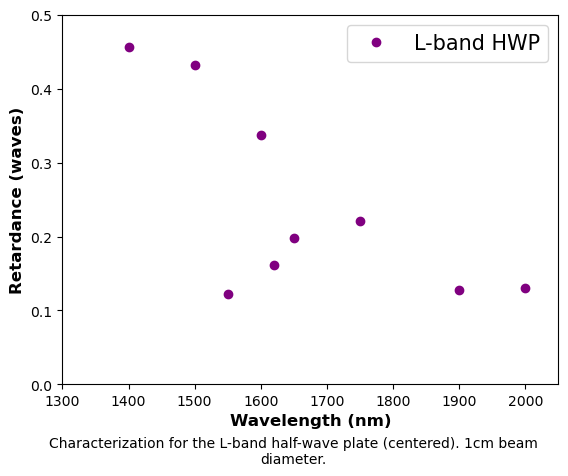

In [38]:
plt.ylim(0, 0.5)
plt.xlim(1300, 2050)
plt.xlabel("Wavelength (nm)", fontsize=12, fontweight='bold')
plt.ylabel("Retardance (waves)", fontsize=12, fontweight='bold')

plt.plot(wavelength_bins, retardance, marker='o', linestyle=' ', color = 'purple', label = 'L-band HWP')

caption = "Characterization for the L-band half-wave plate (centered). 1cm beam diameter."

text_width = 70  # Speify desired text width box in characters
wrapped_text = textwrap.fill(caption, width=text_width)
plt.text(1650, -0.09, wrapped_text, ha='center', va='center')

plt.legend(fontsize=15)

folder_path = r"Z:\\Lab_Data\\Mueller_Matrix_Polarimeter\\L_Plate_Characterization\\"
file_name = 'L_Band_HWP_Retardance.png'
plt.savefig(folder_path + file_name, bbox_inches='tight', dpi=300)